In [23]:
import pandas as pd
import geopandas as gpd
from shapely import geometry
import networkx as nx

gpd.options.use_pygeos = False

In [24]:

import osmnx as ox
import utm
import rtree

from cityseer import tools #numba 0.53.0

In [152]:
# centre-point
lng, lat = 14.4361789, 50.0754014

# select extents for plotting
easting, northing = utm.from_latlon(lat, lng)[:2]
buff = geometry.Point(easting, northing).buffer(200)
min_x, min_y, max_x, max_y = buff.bounds

In [153]:
# reusable plot function
def simple_plot(_G):
    # plot using the selected extents
    tools.plot.plot_nx(
        _G,
        labels=False,
        plot_geoms=True,
        node_size=15,
        edge_width=2,
        x_lim=(min_x, max_x),
        y_lim=(min_y, max_y),
        figsize=(5, 5),
        dpi=70,
    )

# reusable plot function
def color_plot(_G, _node_color):
    # plot using the selected extents
    tools.plot.plot_nx(
        _G,
        labels=False,
        node_colour=_node_color,
        x_lim=(min_x, max_x),
        y_lim=(min_y, max_y),
        figsize=(5, 5),
        dpi=70,
    )
    

def dual_plot(_G1, _G2):
    tools.plot.plot_nx_primal_or_dual(
        _G1, 
        _G2, 
        plot_geoms=False, 
        primal_node_size=15,
        dual_node_size=10,
        x_lim=(min_x, max_x),
        y_lim=(min_y, max_y),
        figsize=(5, 5),
        dpi=70,)


In [154]:
# Let's use OSMnx to fetch an OSM graph
# We'll use the same raw network for both workflows (hence simplify=False)
multi_di_graph_raw = ox.graph_from_point((lat, lng), dist=1250, simplify=False);

INFO:cityseer.tools.graphs:Converting OSMnx MultiDiGraph to cityseer MultiGraph.
100%|██████████| 6260/6260 [00:01<00:00, 5429.04it/s]


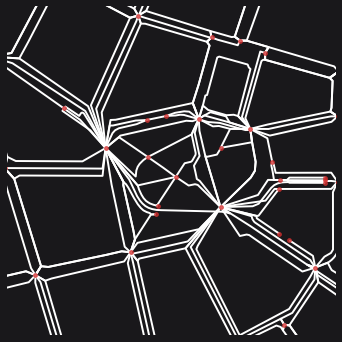

In [155]:

# Workflow 1: Using OSMnx to prepare the graph
# ============================================
# explicit simplification and consolidation via OSMnx
multi_di_graph_utm = ox.project_graph(multi_di_graph_raw)
multi_di_graph_simpl = ox.simplify_graph(multi_di_graph_utm)
multi_di_graph_cons = ox.consolidate_intersections(multi_di_graph_simpl, tolerance=10, dead_ends=True)
# let's use the same plotting function for both scenarios to aid visual comparisons
multi_graph_cons = tools.graphs.nx_from_osm_nx(multi_di_graph_cons, tolerance=50)
simple_plot(multi_graph_cons)

INFO:cityseer.tools.graphs:Converting OSMnx MultiDiGraph to cityseer MultiGraph.
100%|██████████| 32901/32901 [00:05<00:00, 5971.37it/s]
INFO:cityseer.tools.graphs:Converting networkX graph from WGS to UTM.
INFO:cityseer.tools.graphs:Processing node x, y coordinates.
100%|██████████| 15388/15388 [00:00<00:00, 28136.78it/s]
INFO:cityseer.tools.graphs:UTM conversion info: UTM zone number: 33, UTM zone letter: U
INFO:cityseer.tools.graphs:Processing edge geom coordinates, if present.
100%|██████████| 18257/18257 [00:02<00:00, 7228.46it/s] 
INFO:cityseer.tools.graphs:Generating simple (straight) edge geometries.
100%|██████████| 18257/18257 [00:00<00:00, 110840.54it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 15388/15388 [00:01<00:00, 9077.47it/s] 
INFO:cityseer.tools.graphs:Removing dangling nodes.
100%|██████████| 5554/5554 [00:00<00:00, 392835.82it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 5241/5241 [00:00<00:00, 68861.83it/s]
INFO:c

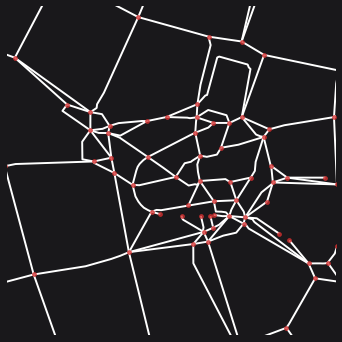

In [156]:

# WORKFLOW 2: Using cityseer to prepare the graph
# ===============================================
# let's convert the OSMnx graph to a cityseer compatible `multiGraph`
G_raw = tools.graphs.nx_from_osm_nx(multi_di_graph_raw)
# convert to UTM
G = tools.graphs.nx_wgs_to_utm(G_raw)
# infer geoms
G = tools.graphs.nx_simple_geoms(G)
# remove degree=2 nodes
G = tools.graphs.nx_remove_filler_nodes(G)
# remove dangling nodes
G = tools.graphs.nx_remove_dangling_nodes(G, despine=10)
# repeat degree=2 removal to remove orphaned nodes due to despining
G = tools.graphs.nx_remove_filler_nodes(G)
# let's consolidate the nodes
G1 = tools.graphs.nx_consolidate_nodes(G, buffer_dist=10, min_node_group=3)
# and we'll try to remove as many parallel roadways as possible
G2 = tools.graphs.nx_split_opposing_geoms(G1, buffer_dist=15)
G3 = tools.graphs.nx_consolidate_nodes(G2, buffer_dist=15, crawl=False, min_node_degree=2, cent_min_degree=4)
simple_plot(G3)

INFO:cityseer.tools.graphs:Converting graph to dual.
100%|██████████| 3153/3153 [00:06<00:00, 477.28it/s]


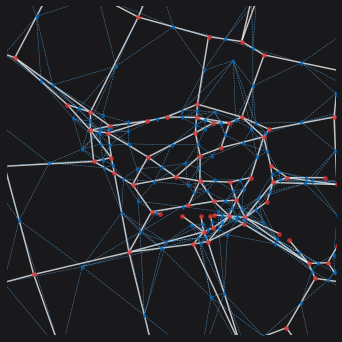

In [157]:
G_dual = tools.graphs.nx_to_dual(G3)
# here we are plotting the newly decomposed graph (blue) against the original graph (red)
dual_plot(G3, G_dual)

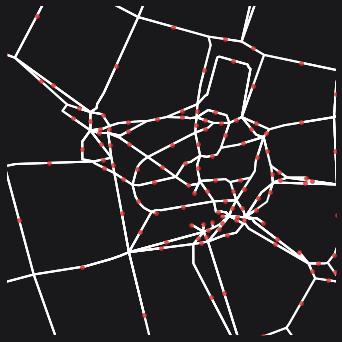

In [158]:
simple_plot(G_dual)

INFO:cityseer.tools.graphs:Decomposing graph to maximum edge lengths of 20.
100%|██████████| 3153/3153 [00:01<00:00, 1731.93it/s]


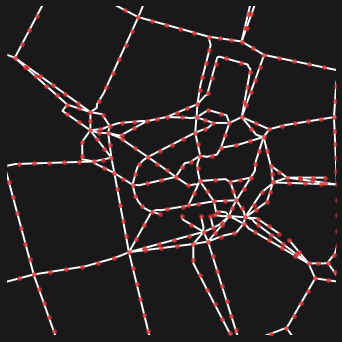

INFO:cityseer.tools.graphs:Preparing node and edge arrays from networkX graph.
100%|██████████| 9586/9586 [00:01<00:00, 5136.94it/s]
INFO:cityseer.metrics.networks:Computing segment_harmonic, segment_betweenness centrality measures using shortest (non-angular) path heuristic.


100%|██████████| 9586.0/9586 [00:00<00:00, 12849.96it/s]


,live,geometry,cc_metric_segment_harmonic_20,cc_metric_segment_harmonic_40,cc_metric_segment_harmonic_80,cc_metric_segment_harmonic_160,cc_metric_segment_harmonic_320,cc_metric_segment_betweenness_20,cc_metric_segment_betweenness_40,cc_metric_segment_betweenness_80,cc_metric_segment_betweenness_160,cc_metric_segment_betweenness_320
node_key,,,,,,,,,,,,
703208,True,POINT (460007.28125 5546090.00000),11.982927,17.651001,25.300568,34.947090,49.722820,61.455872,170.647690,648.104309,3219.859131,17034.519531
703215,True,POINT (458783.00000 5546080.00000),2.995732,3.688879,6.381091,12.659606,21.404213,0.000000,0.000000,0.000000,0.000000,0.000000
1467640477,True,POINT (458847.09375 5548246.00000),8.987196,11.066637,13.603269,18.703096,31.324522,29.765789,62.120464,156.158737,675.753845,4785.762695
300524480,True,POINT (458813.06250 5548283.50000),8.987197,11.066638,13.883563,18.960846,30.641418,29.915970,63.273567,164.864655,716.981262,4654.824707
21311940,True,POINT (460823.21875 5545952.50000),2.995732,3.688879,5.092669,7.227993,13.753247,0.000000,0.000000,0.000000,0.000000,0.000000


In [159]:
from cityseer.metrics import networks

G_decomp = tools.graphs.nx_decompose(G3, 20)
simple_plot(G_decomp)

# create a Network layer from the networkX graph
# use a CRS EPSG code matching the projected coordinate reference system for your data
nodes_gdf, network_structure = tools.graphs.network_structure_from_nx(G_decomp, crs=4326)
# the underlying method allows the computation of various centralities simultaneously, e.g.
nodes_gdf = networks.segment_centrality(
    measures=["segment_harmonic", "segment_betweenness"],  # the form of centrality measures to compute - see docs
    network_structure=network_structure,  # the network structure for which to compute the measures
    nodes_gdf=nodes_gdf,  # the nodes GeoDataFrame, to which the results will be written
    distances=[20,40,80,160,320],  # the distance thresholds for which to compute centralities
)
nodes_gdf.head()  # the results are now in the GeoDataFrame

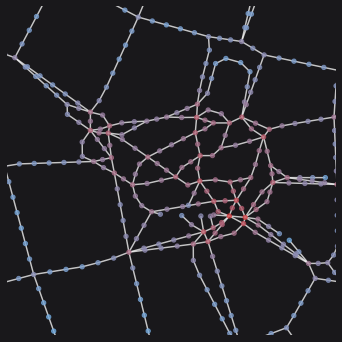

In [165]:
# plot centrality
from matplotlib import colors

# custom colourmap
cmap = colors.LinearSegmentedColormap.from_list("cityseer", ["#64c1ff", "#d32f2f"])
# normalise the values
segment_harmonic_vals = nodes_gdf["cc_metric_segment_harmonic_160"]
segment_harmonic_vals = colors.Normalize()(segment_harmonic_vals)
# cast against the colour map
segment_harmonic_cols = cmap(segment_harmonic_vals)
# plot segment_harmonic
# cityseer's plot methods are used here and in tests for convenience
# that said, rather use plotting methods directly from networkX or GeoPandas where possible
color_plot(G_decomp, segment_harmonic_cols)

In [201]:
from cityseer.metrics import layers

# a mock data dictionary representing categorical landuse data
# here randomly generated letters represent fictitious landuse categories
data_gdf = tools.mock.mock_landuse_categorical_data(G_decomp, length=2000,random_seed=20)
data_gdf.head()
print(data_gdf.shape)

(2000, 2)


In [207]:
# example easy-wrapper method for computing mixed-uses
# this is a distance weighted form of hill diversity
nodes_gdf, data_gdf = layers.hill_branch_wt_diversity(
    data_gdf,  # the source data
    landuse_column_label="categorical_landuses",  # column in the dataframe which contains the landuse labels
    nodes_gdf=nodes_gdf,  # nodes GeoDataFrame - the results are written here
    network_structure=network_structure,  # measures will be computed relative to pedestrian distances over the network
    distances=[20,40,80,160,320,500],  # distance thresholds for which you want to compute the measures
    qs=[0, 1, 2],  # q parameter for hill mixed uses
)
print(nodes_gdf.columns)  # the GeoDataFrame will contain the results of the calculations
#print(nodes_gdf["cc_metric_hill_branch_wt_q0_320"])  # which can be retrieved as needed

INFO:cityseer.metrics.layers:Computing mixed-use measures: hill_branch_wt


100%|██████████| 9586.0/9586 [00:00<00:00, 30825.01it/s]
Index(['live', 'geometry', 'cc_metric_segment_harmonic_20',
       'cc_metric_segment_harmonic_40', 'cc_metric_segment_harmonic_80',
       'cc_metric_segment_harmonic_160', 'cc_metric_segment_harmonic_320',
       'cc_metric_segment_betweenness_20', 'cc_metric_segment_betweenness_40',
       'cc_metric_segment_betweenness_80', 'cc_metric_segment_betweenness_160',
       'cc_metric_segment_betweenness_320', 'cc_metric_hill_branch_wt_q0_20',
       'cc_metric_hill_branch_wt_q0_40', 'cc_metric_hill_branch_wt_q0_80',
       'cc_metric_hill_branch_wt_q0_160', 'cc_metric_hill_branch_wt_q0_320',
       'cc_metric_hill_branch_wt_q1_20', 'cc_metric_hill_branch_wt_q1_40',
       'cc_metric_hill_branch_wt_q1_80', 'cc_metric_hill_branch_wt_q1_160',
       'cc_metric_hill_branch_wt_q1_320', 'cc_metric_hill_branch_wt_q2_20',
       'cc_metric_hill_branch_wt_q2_40', 'cc_metric_hill_branch_wt_q2_80',
       'cc_metric_hill_branch_wt_q2_160', 'c

In [208]:
# reusable plot function
def assignement_plot(_structure, _G, _data, _colors):
    # plot using the selected extents
    tools.plot.plot_assignment(
        _structure,
        _G,
        _data,
        node_colour=_colors,
        data_labels=_data["categorical_landuses"].values,
        figsize=(25, 25),
        dpi=70,
        #x_lim=(min_x, max_x),
        #y_lim=(min_y, max_y),
    )


/home/metamat/anicka/META/block/venv/lib/python3.9/site-packages/cityseer/tools/plot.py:546: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


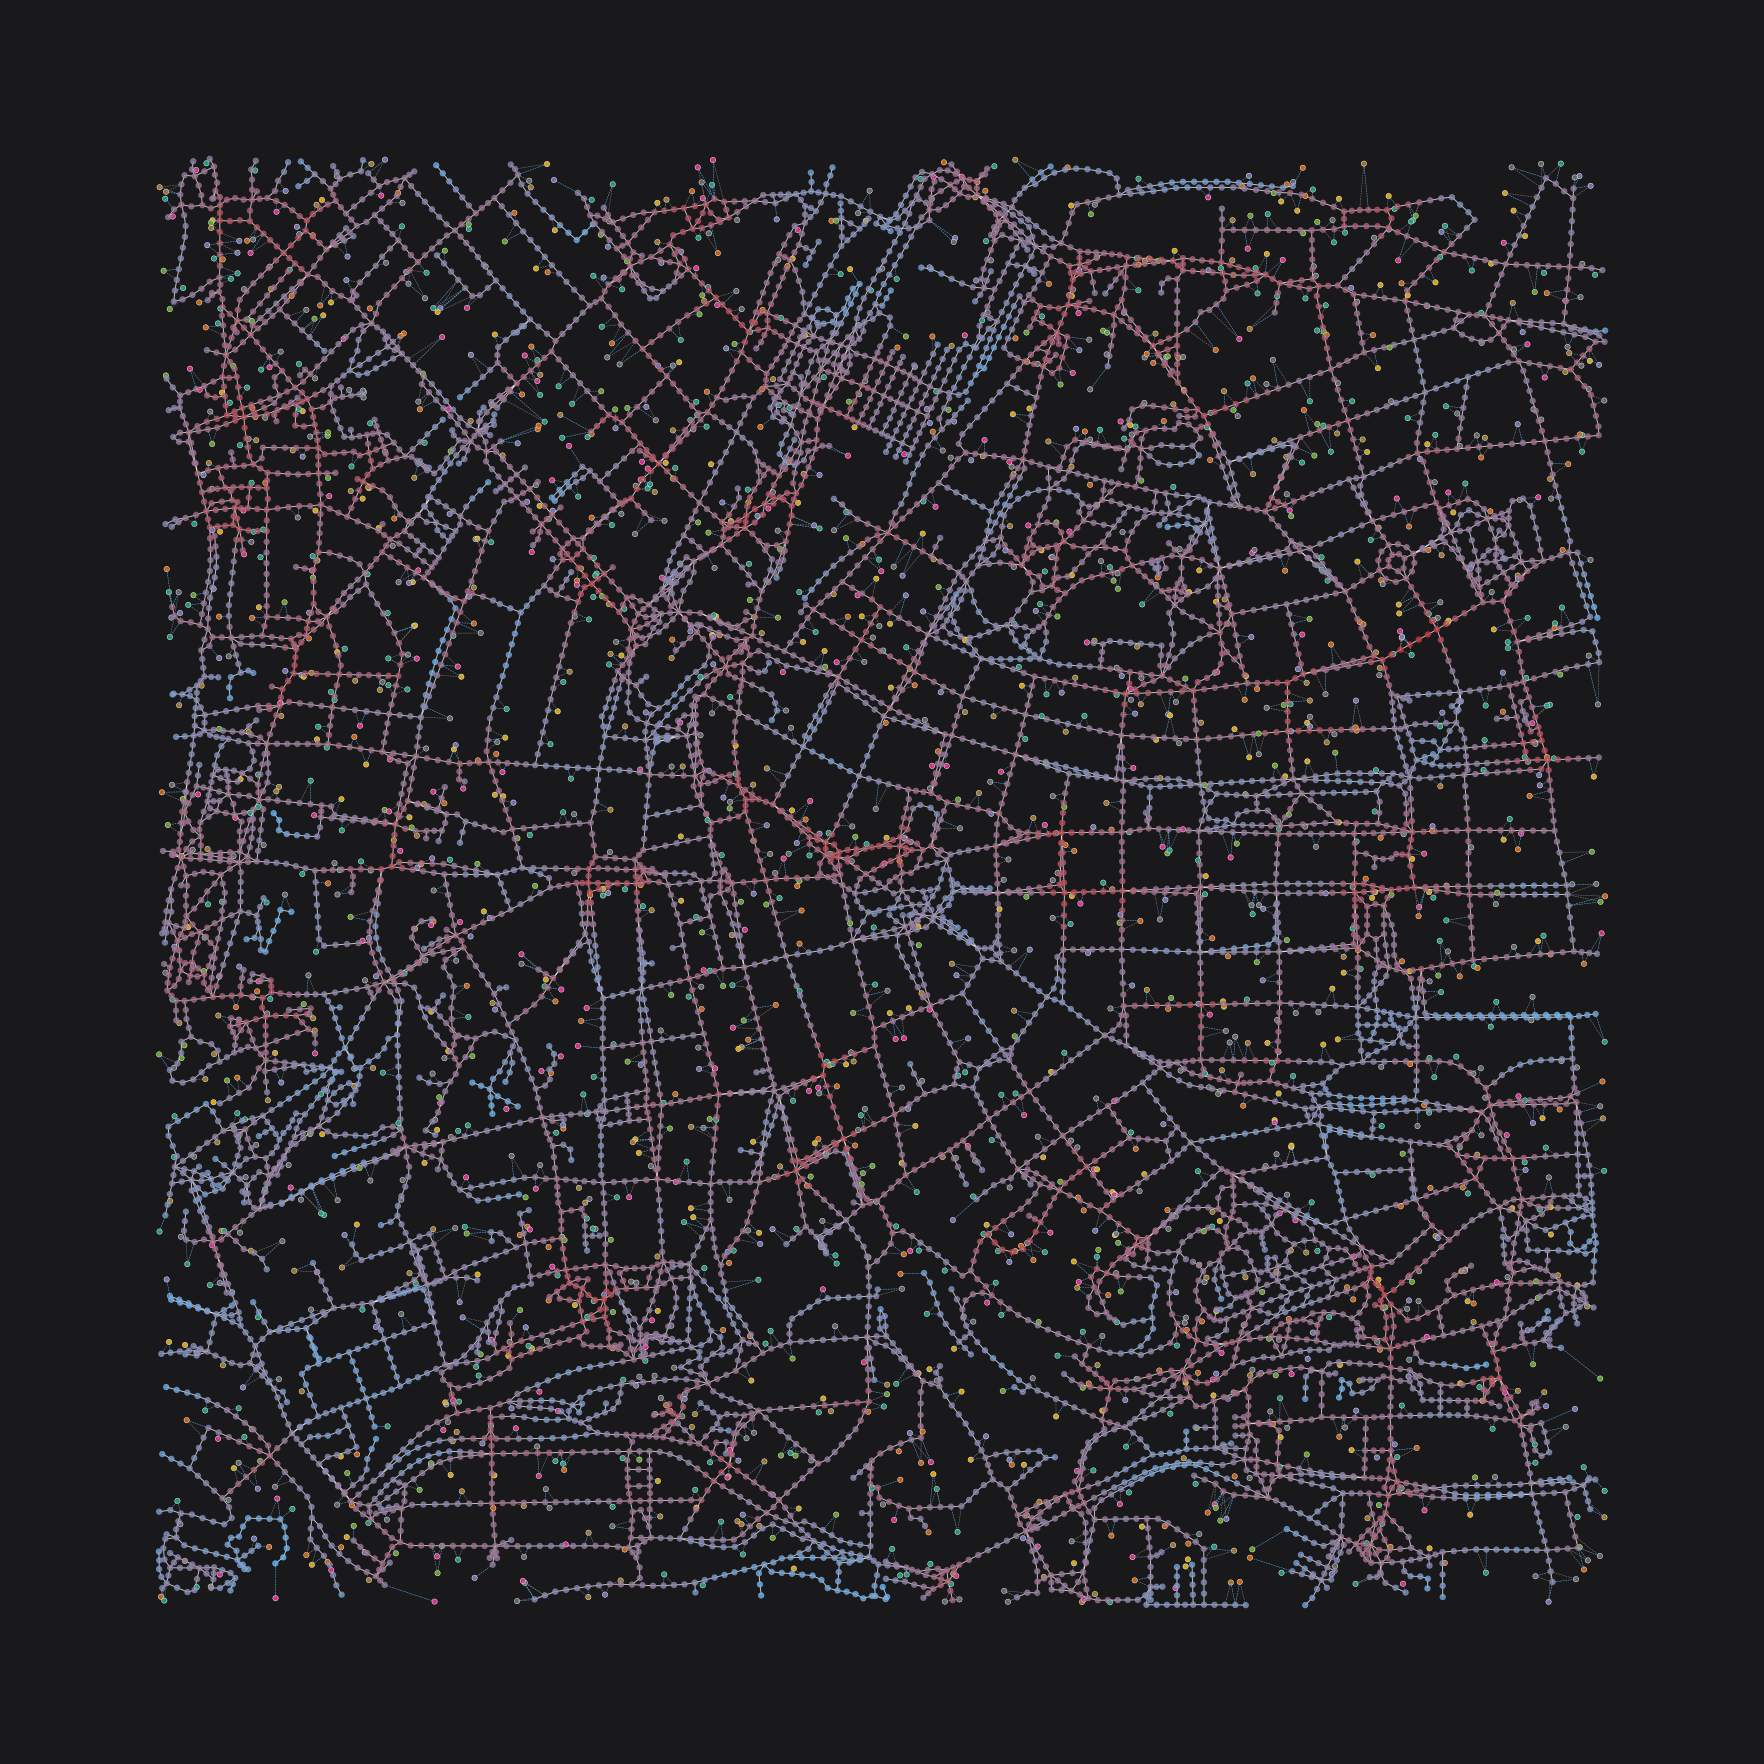

In [209]:
# plot distance-weighted hill mixed uses
mixed_uses_vals = nodes_gdf["cc_metric_hill_branch_wt_q0_500"]
mixed_uses_vals = colors.Normalize()(mixed_uses_vals)
mixed_uses_cols = cmap(mixed_uses_vals)
assignement_plot(
    network_structure,
    G_decomp,
    data_gdf,
    mixed_uses_cols
)